In [4]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

## US Census Trade Data API to bring in trade data

I use this a lot. Here is the [documentation](https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf)

In [29]:
trade_type = "imports"


my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

In [18]:
concordance = pq.read_table(".\\data\\alt_concordance.parquet").to_pandas()

concordance.head()

dict_concordance = dict(zip(concordance.hs6,concordance.naics)) 

In [17]:
def census_trade(url, trade_type, country):
    
    r = requests.get(url) 
    
    print(r)
    
    df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

    df.columns = r.json()[0]

    df.time = pd.to_datetime(df.time, format="%Y-%m")
    # This is so I can call this correctly...
    
    if trade_type == "imports":
        
        trade_label = country + "_" + trade_type
        
        df[trade_label] = df["CON_VAL_MO"].astype(float)
        
        df["hs6"] = df["I_COMMODITY"].astype(str)
        
        df.drop(["CON_VAL_MO", "I_COMMODITY", "COMM_LVL"], axis = 1, inplace = True)
        
    if trade_type == "exports":
    
        trade_label = country + "_" + trade_type
        
        df[trade_label] = df["ALL_VAL_MO"].astype(float)

        df["hs6"] = df["E_COMMODITY"].astype(str)
        
        df.drop(["ALL_VAL_MO", "E_COMMODITY", "COMM_LVL"], axis = 1, inplace = True)
        
    df["naics"] = df["hs6"].map(dict_concordance)

    df["naics3"] = df["naics"].str[0:3]
    
    return df

In [31]:
print("")
print("**********************************************************************************")
print("Downloading and processing Trade Data")
print("")

end_use = "hs?get=I_COMMODITY,CON_VAL_MO"
# Because these are imports, we need the I_COMMODITY flag,
# Then we will grapb the "CON_VAL_MO" which is consumption in the sense
# that it is intended for use in the US, not going someplace else

url = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 
url = url + my_key + "&time==from+2015-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

df_china_trade = census_trade(url, trade_type, "china")


**********************************************************************************

<Response [200]>


In [1]:
print("")
print("**********************************************************************************")
print("Downloading and processing Trade Data")
print("")

end_use = "hs?get=I_COMMODITY,CON_VAL_MO"

url = "https://api.census.gov/data/timeseries/intltrade/imports/"
url = url + end_use + my_key + "&time==from+2015-01" + "&COMM_LVL=HS6"

r = requests.get(url) 

df_all_trade = census_trade(url, trade_type, "total")


**********************************************************************************



NameError: name 'my_key' is not defined

In [22]:
df_all_trade.head()

,time,COMM_LVL,total_imports,hs6,naics,naics3
0,2015-01-01,HS6,3718193.0,920110,339992,339
1,2015-01-01,HS6,7334059.0,920120,339992,339
2,2015-01-01,HS6,23734.0,920190,339992,339
3,2015-01-01,HS6,2604236.0,920210,339992,339
4,2015-01-01,HS6,11963327.0,920290,339992,339


In [30]:
grp = df_all_trade.groupby("time")

agg_trade = grp.agg({"total_imports": "sum"})

agg_trade.tail()
# This should match up closely with FRED 

,total_imports
time,
2019-11-01,1.995955e+11
2019-12-01,2.026007e+11
2020-01-01,1.970581e+11
2020-02-01,1.781228e+11
2020-03-01,1.937152e+11


In [34]:
foo_label = "china"+ "_" + trade_type

dftrade = df_all_trade.merge(df_china_trade[["hs6", "time",foo_label]], left_on = ["hs6", "time"], 
                             right_on = ["hs6", "time"], how = "left")
    

dftrade.set_index("time", inplace = True)

In [35]:
dftrade.head()

,COMM_LVL,total_imports,hs6,naics,naics3,china_imports
time,,,,,,
2015-01-01,HS6,3718193.0,920110,339992,339,762175.0
2015-01-01,HS6,7334059.0,920120,339992,339,992159.0
2015-01-01,HS6,23734.0,920190,339992,339,9000.0
2015-01-01,HS6,2604236.0,920210,339992,339,2066498.0
2015-01-01,HS6,11963327.0,920290,339992,339,6705452.0


### Bring in Tariffs


In [125]:
# bring in the tariff data

tariffs = pd.read_csv(".\\data\\us_tariffs_2020.csv", dtype = {"hs6": str})
# This is the tariff dataset created by updated_tariff_data.ipynb (note the max tariff means taking the largest value
# when going from Chinese hs10 to hs6. This does not matter, if anything gives more conservative resutls)

tariffs.time_of_tariff = pd.to_datetime(tariffs.time_of_tariff, format="%Y-%m-%d")
# make sure the time is there.

tariffs.set_index("time_of_tariff",inplace = True)

In [126]:
tariff_times = list(tariffs.index.unique())
# This grabs the unique times

tariff_dict_list = []
# Then we will create a list of dictionaries where the dictionary
# is setup so it's like you tell me hs6, I tell you tariff. Then
# each entry in the list corresponds with a different mapping

for xxx in tariff_times:
        
    foo_tariff_dict = dict(zip(tariffs.loc[xxx].hs6,tariffs.loc[xxx].tariff)) 
    # This creates the you tell me hs6, I tell you tariff dictionary
    
    tariff_dict_list.append(foo_tariff_dict)
    # Then this populates the list

In [127]:
tariff_dates = ["2015-01", "2018-07", "2018-09", "2018-10", "2019-06", "2019-09", "2020-02"]
# Now these are the tariff dates at monthly frequency

tariff_actions = dict(zip(tariff_dates, tariff_dict_list))
# Then this creates a dictionary, so you tell me the date, I give you the dictionary

In [128]:
initial_tariff = tariff_actions["2015-01"]
dftrade["tariff"] = 0

for date in tariff_dates:
    
    initial_tariff.update(tariff_actions[date])
    # Update the tariff mapping
    
    dftrade.loc[date:,"tariff"] = dftrade.loc[date:,"hs6"].map(initial_tariff)
    # This then takes the hs6 codes at that date, then creates the tariff 
    # given the dictionary created above.

In [129]:
dftrade_17 = dftrade.loc["2017"].groupby("I_COMMODITY").agg({"china_trade":"sum"})

dftrade_17["hs6"] = dftrade_17.index

dftrade_17["naics"] = dftrade_17["hs6"].map(dict_concordance)

dftrade_17["naics4"] = dftrade_17["naics"].str[0:4]

dftrade_17["naics3"] = dftrade_17["naics"].str[0:3]

dftrade_17.rename({"china_trade":"2017_china_trade"}, axis = 1, inplace = True)

In [130]:
dftrade_17_naics3 = dftrade_17.groupby("naics3").agg({"2017_china_trade": "sum"})

dftrade_17_naics3.to_csv(".//data//2017_imports_by_naics.csv")

In [131]:
dftrade = dftrade.merge(dftrade_17["2017_china_trade"], how = "inner", left_on = "I_COMMODITY", right_index = True)

In [132]:
dftrade.head()

,I_COMMODITY,COMM_LVL,total_trade,china_trade,hs6,naics,naics4,naics3,tariff,2017_china_trade
time,,,,,,,,,,
2015-01-01,920110,HS6,3718193.0,762175.0,920110,339992,3399,339,4.7,5446271.0
2015-02-01,920110,HS6,2273752.0,382584.0,920110,339992,3399,339,4.7,5446271.0
2015-03-01,920110,HS6,5169349.0,714091.0,920110,339992,3399,339,4.7,5446271.0
2015-04-01,920110,HS6,4179907.0,617589.0,920110,339992,3399,339,4.7,5446271.0
2015-05-01,920110,HS6,3328202.0,512615.0,920110,339992,3399,339,4.7,5446271.0


In [133]:
def trd_weighted_avg(df):
    # A function to create the trade weighted average of the tariff rates
    # by round...
    
    trd_w_avg = df["tariff"].multiply(df["2017_china_trade"],axis = 0).sum() 
    # here wuse the 2017 annual values to weight it
    
    trd_w_avg = trd_w_avg / df["2017_china_trade"].sum()
    
    
    foo = {"tariff_trd_w_avg": [trd_w_avg ], 
           "total_trade": df["total_trade"].sum(),
          "china_trade" : df["china_trade"].sum()}
    
    return pd.DataFrame(foo)

In [134]:
grp = dftrade.groupby(["time","naics3"])

imports_bynaics = grp.apply(trd_weighted_avg)

imports_bynaics = imports_bynaics.droplevel(2)

In [135]:
imports_bynaics.head()

imports_bynaics.to_csv(".//data//imports_by_naics.csv")

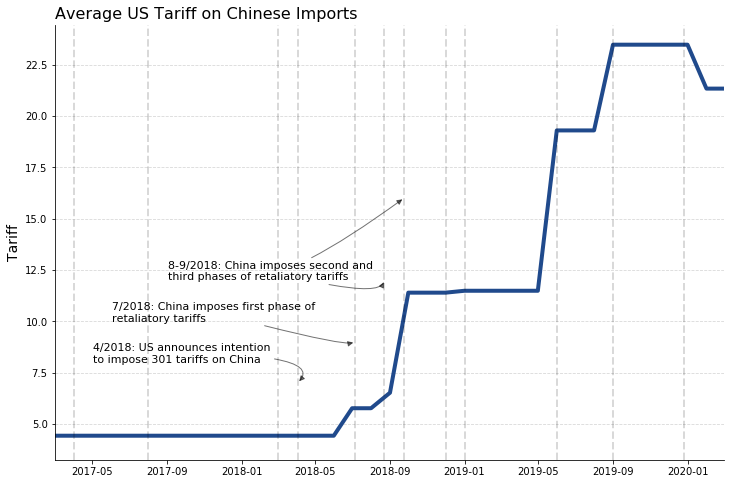

In [137]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

tariffs_over_time = imports_bynaics.groupby(["time"]).agg({"tariff_trd_w_avg": "mean"})

ax.plot(tariffs_over_time, alpha = 0.95, color = mike_blue, linewidth = 4)

#ax.plot(auto_least, alpha = 0.95, color = mike_blue, linewidth = 4, 
#        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_xlim(dt.datetime(2017,3,1),dt.datetime(2020,3,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

label_descrip = "Tariff"

ax.set_ylabel(label_descrip, fontsize = 14)

ax.axvline(dt.datetime(2017,4,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2017,8,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,3,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,1,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,6,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,9,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2019,12,26), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.set_title("Average US Tariff on Chinese Imports", fontsize = 16, loc= "left" )


##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose 301 tariffs on China", 
    xy=(dt.datetime(2018,4,3), 7), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,5,3), 8), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=0,angleB=45",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), 9), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,6,3), 10), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), 12), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,9,3), 12), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phases of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), 16), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2017,9,3), 12), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=3,angleB=36",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################


##############################################################################################

#

#if not os.path.exists(fig_path):
#    os.makedirs(fig_path)
    
#plt.savefig(fig_path + "\\tariffs_time.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

In [138]:
imports_bynaics.head()

tariff_trd_w_avg   total_trade  china_trade
time       naics3                                             
2015-01-01 111             2.691070  3.237275e+09   63674530.0
           112             0.016408  3.739969e+08     889946.0
           113             1.016320  1.969950e+08   15953858.0
           114             1.500939  1.440097e+09  285216144.0
           211             0.000000  1.232820e+10      75188.0